## Tensorflow Object Detection API

Учим модель распознавать моноколеса. Выполнено в Google Colab, код работает на tensorflow 1.15

In [1]:
# Импорт необходимых библиотек

import os
import urllib.request
import shutil

In [2]:
"""Settings"""

# Путь к папке проекта
ROOT_DIR = os.path.abspath('.')
# Путь к локальной версии библиотеки keras-retinanet
KERAS_RETINANET_PATH = os.path.join(ROOT_DIR, "keras-retinanet")
# Путь к предобученной модели
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "resnet50_coco_best_v2.1.0.h5")
# Ссылка на скачивание модели
COCO_MODEL_URL = "https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5"

In [3]:
# Установка keras-retinanet

if not os.path.exists(KERAS_RETINANET_PATH):
    !git clone https://github.com/fizyr/keras-retinanet.git
    !cd keras-retinanet \
        && git reset --hard abe89380835bc06dff3b97e69fa2b19dd7fd97a8 \
        && pip install . \
        && python setup.py build_ext --inplace
      
# Скачивание предобученных весов resnet50 для датасета coco
    
if not os.path.exists(COCO_MODEL_PATH):
    with urllib.request.urlopen(COCO_MODEL_URL) as resp, open(COCO_MODEL_PATH, 'wb') as out:
        shutil.copyfileobj(resp, out)

In [ ]:
!python keras-retinanet/keras_retinanet/bin/train.py \
    --random-transform \
    --weights "./resnet50_coco_best_v2.1.0.h5" \
    --steps 100 \
    --epochs 20 \
    csv "data/annotations.csv" "data/classes.csv"

## Конвертация обученной модели для инференса

In [4]:
!python keras-retinanet/keras_retinanet/bin/convert_model.py \
    snapshots/resnet50_csv_20.h5 \
    snapshots/inference_model.h5

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

2020-06-02 16:41:18.805939: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_101.dll
2020-06-02 16:41:20.645751: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library nvcuda.dll
2020-06-02 16:41:20.660967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.8475GHz coreCount: 20 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 298.32GiB/s
2020-06-02 16:41:20.661334: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_101.dll
2020-06-02 16:41:20.676784: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cublas64_10.dll
2020-06-02 16:41:20.692401: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cufft64_10.dll
2

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[ -90.50967 ,  -45.254833,   90.50967 ,   45.254833],
       [-114.03504 ,  -57.01752 ,  114.03504 ,   57.01752 ],
       [-143.67514 ,  -71.83757 ,  143.67514 ,   71.83757 ],
       [ -64.      ,  -64.      ,   64.      ,   64.      ],
       [ -80.63495 ,  -80.63495 ,   80.63495 ,   80.63495 ],
       [-101.593666, -101.593666,  101.593666,  101.593666],
       [ -45.254833,  -90.50967 ,   45.254833,   90.50967 ],
       [ -57.01752 , -114.03504 ,   57.01752 ,  114.03504 ],
       [ -71.83757 , -143.67514 ,   71.83757 ,  143.67514 ]],
      dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-181.01933,  -90.50967,  181.01933,   90.50967],
       [-228.07008, -114.03504,  228.07008,  114.03504],
       [-287.35028, -143.67514,  287.35028,  143.67514],
       [-128.     , -128.     ,  128.     ,  128.     ],
       [-161.2699 , -161.2699 ,  161.2699 ,  161.269

## Загрузка необходимых библиотек

In [5]:
import time
import imageio
from matplotlib import pyplot as plt
import matplotlib.patches as patches

from keras_retinanet.models import load_model
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.colors import label_color

## Загрузка модели для инференса

In [6]:
model = load_model('snapshots/inference_model.h5', backbone_name='resnet50')

Using TensorFlow backend.


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

D:\anaconda\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Загрузка словаря с метками классов

In [7]:
labels_to_names = {}
with open('data/classes.csv') as f:
    for line in f:
        cls_name, cls_id = line.split(',')
        labels_to_names[int(cls_id.strip())] = cls_name.strip()
print(labels_to_names)

{0: 'expander'}


## Функция применения модели для детектирования объектов

In [8]:
def detect_objects(image):    
    image_processed = preprocess_image(image[:,:,::-1].copy())
    image_processed, scale = resize_image(image_processed)

    start = time.time()
    boxes, scores, labels = model.predict(image_processed[None, ...])
    print("Processing time: ", time.time() - start)
    boxes /= scale
    return boxes[0], scores[0], labels[0]

## Функция визуализации результатов детектирования объектов

In [9]:
def draw_predictions(image, predictions=None):
    draw = image.copy()
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(draw)

    if predictions is None:
        return
        
    boxes, scores, labels = predictions
    SCORE_THRESHOLD = 0.5
    for box, score, label in zip(boxes, scores, labels):
        if score < SCORE_THRESHOLD:
            break

        box_y = int(box[1])
        box_x = int(box[0])
        box_h = int(box[3]-box[1])
        box_w = int(box[2]-box[0])
        caption = "{} {:.3f}".format(labels_to_names[label], score)
        if 0:
            color = [x/255 for x in label_color(label)]
        else:
            color =  [(0, 1, 0), (1, 1, 0), (1, 0, 1), (1, 0, 0)][label]

        label_size = 20
        plt_scale = float(fig.get_size_inches()[1]) * fig.dpi * draw.shape[0] * label_size / 12545280
        ax.add_patch(patches.Rectangle((box_x, box_y), 
                                 box_w, box_h, 
                                 linewidth=2, edgecolor=color, facecolor='none'))
        ax.add_patch(patches.Rectangle((box_x, box_y-round(26*plt_scale)), 
                                 round(plt_scale*len(caption)*14), round(26*plt_scale), 
                                 linewidth=2, edgecolor=color, facecolor=color))
        ax.text(box_x + round(3*plt_scale), box_y - round(5*plt_scale), caption, fontsize=label_size)

## Детектирование объектов на тестовом изображении

Processing time:  3.680586814880371


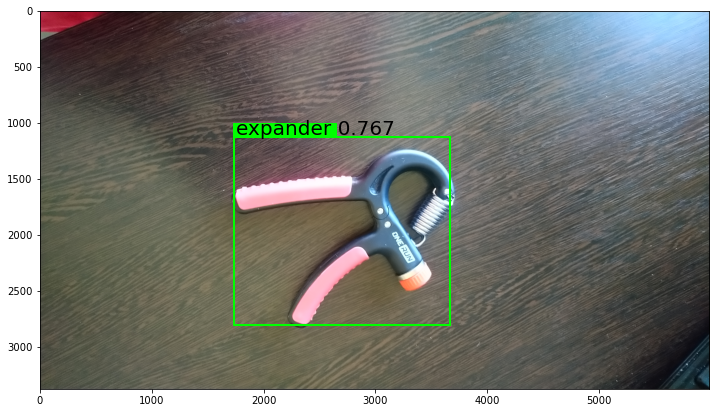

In [11]:
image = imageio.imread('data/test-1.JPG')
predictions = detect_objects(image)
draw_predictions(image, predictions)

В целом получился довольно интересный "игрушечный" пример